Load bitstream

In [1]:
from pynq import Xlnk
from pynq import Overlay
import numpy as np 
import wave
import math
import numpy as np
import matplotlib.pyplot as plt
xlnk = Xlnk()
music_design = Overlay("./bitstream/music.bit")
music = music_design.music_0
dma = music_design.axi_dma_0

Load audio from 4 channels

In [3]:
wav_path = ["./test_audio/test_2_ch_1.wav","./test_audio/test_2_ch_2.wav", "./test_audio/test_2_ch_3.wav", "./test_audio/test_2_ch_4.wav"]
X_re = xlnk.cma_array(shape=(10240,4), dtype=np.float32)
X_im = xlnk.cma_array(shape=(10240,4), dtype=np.float32)
P_sm = xlnk.cma_array(shape=(361,), dtype=np.float32)
for i in range(4):
    f = wave.open(wav_path[i], 'r')
    f_data = f.readframes(10240) 
    wave_data = np.fromstring(f_data, dtype = np.short)
    X_re.T[:][i] = wave_data

Invoke hardware function

In [4]:
music.write(0x18, X_re.physical_address)
music.write(0x20, X_im.physical_address)
dma.recvchannel.transfer(P_sm) 
music.write(0x00, 0x1)
dma.recvchannel.wait()

Find power peaks

In [43]:
p_max = np.zeros(361)
index = []
for i in range(361):
    if (i > 0) and (i < 360):
        if((P_sm[i] >= P_sm[i-1]) and (P_sm[i] >= P_sm[i+1])):
            p_max[i] = P_sm[i]
    index.append(i)
for i in range(360):
    flag = i;
    for j in range(flag+1, 361):
        if (p_max[index[flag]] > p_max[index[j]]):
            flag = j;
    temp = 0;
    temp = index[flag];
    index[flag] = index[i];
    index[i] = temp;
DOA1 = 0.5 * index[360] - 90;
DOA2 = 0.5 * index[359] - 90;
print("DOA1: "+str(DOA1)+"deg", "DOA2: "+str(DOA2)+"deg")

DOA1: 7.0deg DOA2: 63.0deg


Plot Spacial Sectrum

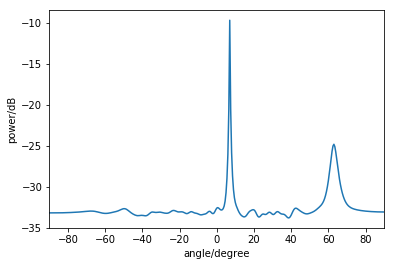

In [54]:
angle = np.zeros(361)
P = np.zeros(361)
for i in range(361):
    angle[i] = i*0.5 - 90
    P[i] = 10*math.log(P_sm[i],10)
    
plt.plot(angle, P)
plt.xlim(-90, 90)
plt.xlabel("angle/degree")
plt.ylabel("power/dB")
plt.show()

In [56]:
X_re.close()
X_im.close()
P_sm.close()
xlnk.xlnk_reset()